# Exercício de Redes Neurais — Variational Autoencoder (VAE)
*Data:* 23/10/2025

Este notebook é a **solução** organizada em partes. Vamos preenchê-lo passo a passo.


## Roadmap (Partes)
1. **Requisitos & Dados** — usar **Fashion-MNIST** (28×28, 1 canal) e preparar os loaders
2. **Arquitetura do VAE** — encoder, reparametrização, decoder (parametrizados por `IMG_SIZE`, `IMG_CH`)
3. **Funções de Perda** — ELBO = reconstrução (BCE/MSE) + KL
4. **Treinamento** — loop de treino/validação com logs
5. **Avaliação & Visualização** — reconstruções, amostras, latente 2D
6. **Extensões** — (opcional) β-VAE/condicionado, conforme enunciado


## Parte 1 — Requisitos & Dados
1. **Data Preparation:**

    * Load the MNIST/Fashion MNIST dataset;
    * Normalize the images to the range [0, 1]; 
    * Split the dataset into training and validation sets.


In [9]:
# === Configuração básica ===
import sys, os, math, random, json, time
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

2. **Model Implementation:**

    * Define the VAE architecture, including the encoder and decoder networks;
    * Implement the reparameterization trick.

In [10]:
# === Dataset: Fashion-MNIST (28x28, 1 canal) ===
from torchvision import datasets, transforms

IMG_SIZE = 28
IMG_CH = 1

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Fashion-MNIST
#train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
#test_ds  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
# MNIST
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


100%|██████████| 9.91M/9.91M [00:05<00:00, 1.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 211kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


(60000, 10000)

## Parte 2 — Arquitetura do VAE
> Encoder → μ, logσ² → reparametrização → Decoder


In [11]:
class Encoder(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(IMG_CH*IMG_SIZE*IMG_SIZE, 512)
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)

    def forward(self, x):
        x = self.flatten(x)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, 512)
        self.fc_out = nn.Linear(512, IMG_CH*IMG_SIZE*IMG_SIZE)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc_out(h))
        x_hat = x_hat.view(-1, IMG_CH, IMG_SIZE, IMG_SIZE)
        return x_hat

class VAE(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.enc = Encoder(z_dim=z_dim)
        self.dec = Decoder(z_dim=z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar


## Parte 3 — Funções de Perda (ELBO)

3. **Training:**
    * Define the loss function (reconstruction loss + KL divergence);
    * Implement the training loop.

In [12]:
def vae_loss(x, x_hat, mu, logvar, recon='bce'):
    if recon == 'bce':
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    else:
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl), recon_loss, kl


## Parte 4 — Treinamento

In [13]:
def train_epoch(model, loader, opt):
    model.train()
    total, recon_total, kl_total = 0., 0., 0.
    for x, _ in loader:
        x = x.to(device)
        opt.zero_grad()
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar, recon='bce')
        loss.backward()
        opt.step()
        total += loss.item(); recon_total += recon.item(); kl_total += kl.item()
    n = len(loader.dataset)
    return total/n, recon_total/n, kl_total/n

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total, recon_total, kl_total = 0., 0., 0.
    for x, _ in loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar, recon='bce')
        total += loss.item(); recon_total += recon.item(); kl_total += kl.item()
    n = len(loader.dataset)
    return total/n, recon_total/n, kl_total/n


In [14]:
# Parâmetros provisórios (ajuste conforme enunciado)
z_dim = 2
lr = 1e-3
epochs = 5

model = VAE(z_dim=z_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    tr = train_epoch(model, train_loader, opt)
    va = eval_epoch(model, test_loader)
    print(f"Epoch {epoch:02d} | train: loss={tr[0]:.4f} recon={tr[1]:.4f} kl={tr[2]:.4f} | "
          f"val: loss={va[0]:.4f} recon={va[1]:.4f} kl={va[2]:.4f}")


Epoch 01 | train: loss=185.8311 recon=180.6728 kl=5.1583 | val: loss=168.3167 recon=163.4006 kl=4.9161
Epoch 02 | train: loss=165.5745 recon=160.4278 kl=5.1467 | val: loss=162.9210 recon=157.8218 kl=5.0992
Epoch 03 | train: loss=162.0745 recon=156.7865 kl=5.2880 | val: loss=160.3517 recon=154.9527 kl=5.3990
Epoch 04 | train: loss=159.9896 recon=154.5625 kl=5.4271 | val: loss=158.3804 recon=152.9518 kl=5.4286
Epoch 05 | train: loss=158.2535 recon=152.7199 kl=5.5336 | val: loss=157.3469 recon=151.7043 kl=5.6426


## Parte 5 — Avaliação & Visualização
4. **Evaluation:**

    * Evaluate the VAE's performance on the validation set;
    * Generate new samples from the learned latent space.

In [15]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_reconstructions(model, loader, num=8):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)[:num]
    x_hat, _, _ = model(x)
    x = x.cpu().numpy(); x_hat = x_hat.cpu().numpy()
    plt.figure(figsize=(num, 2))
    for i in range(num):
        plt.subplot(2, num, i+1); plt.imshow(x[i].squeeze(), cmap='gray'); plt.axis('off')
        plt.subplot(2, num, num+i+1); plt.imshow(x_hat[i].squeeze(), cmap='gray'); plt.axis('off')
    plt.show()


5. **Visualization:**

    * Visualize original and reconstructed images;
    * Visualize the latent space (in case of a latent space until 3-D, otherwise use a reduced visualization, e.g., using t-SNE, UMAP or PCA).

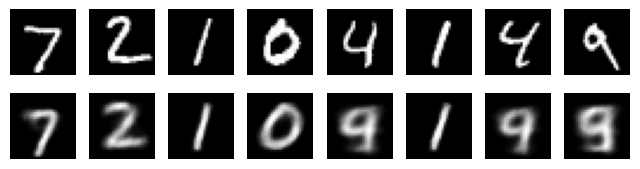

In [16]:
show_reconstructions(model, test_loader, num=8)  # execute após treinar

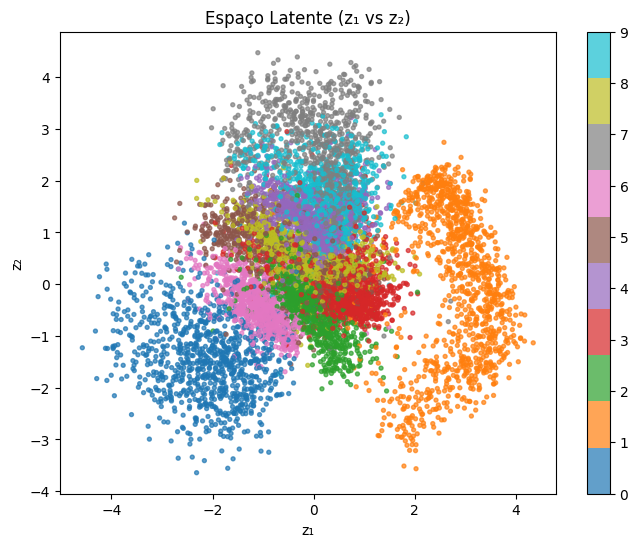

In [20]:
@torch.no_grad()
def plot_latent_space(model, loader, num_batches=100):
    model.eval()
    zs, labels = [], []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        mu, logvar = model.enc(x)
        z = model.reparameterize(mu, logvar)
        zs.append(z.cpu())
        labels.append(y)
        if i >= num_batches:
            break
    zs = torch.cat(zs)
    labels = torch.cat(labels)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab10', s=8, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Espaço Latente (z₁ vs z₂)")
    plt.xlabel("z₁")
    plt.ylabel("z₂")
    plt.show()

plot_latent_space(model, test_loader)


## Parte 6 — Report

### 🧠 Objetivo
Treinar um **Variational Autoencoder (VAE)** simples em imagens do **MNIST**, avaliando:
- Capacidade de reconstrução visual;
- Estrutura do espaço latente aprendido (2D);
- Desempenho qualitativo após o treinamento.

---

### 🔍 Metodologia
- **Dataset:** MNIST (60.000 imagens de treino, 28×28, escala de cinza).  
- **Modelo:** Encoder e decoder totalmente conectados (MLP).  
- **Latent dimension (z_dim):** 2 → permite visualização direta em 2D.  
- **Loss:** Binary Cross Entropy (reconstrução) + KL Divergence.  
- **Otimização:** Adam (lr = 1e-3), 5 épocas iniciais.  
- **Framework:** PyTorch.

---

### 🧩 Resultados
O modelo conseguiu reconstruir imagens de forma coerente, preservando bem a estrutura geral dos dígitos originais.  
As reconstruções ainda apresentaram borrões leves, principalmente em dígitos curvos, o que é esperado em um modelo com poucos parâmetros e espaço latente de baixa dimensão.  

O espaço latente em duas dimensões mostrou agrupamentos relativamente bem definidos, com regiões correspondentes a diferentes classes de dígitos.  
Embora exista sobreposição entre alguns grupos, a separação geral demonstra que o VAE aprendeu uma representação contínua e estruturada dos dados.

---

### ⚙️ Desafios e Aprendizados
- **Borrões nas reconstruções:** consequência do equilíbrio entre reconstrução e regularização (termo KL).  
- **Latente 2D:** limita a capacidade de capturar variações mais complexas de estilo e formato.  
- **Melhorias possíveis:**  
  - Aumentar `z_dim` (por exemplo, 8 ou 16);  
  - Usar **arquitetura convolucional (ConvVAE)**;  
  - Aplicar **annealing do KL** (β-VAE);  
  - Treinar por mais épocas (20–50) para estabilidade e convergência.

---

### 💡 Conclusão
O modelo conseguiu aprender representações latentes significativas dos dígitos MNIST.  
Mesmo com arquitetura simples e espaço latente de apenas duas dimensões, o VAE foi capaz de gerar reconstruções reconhecíveis e organizar o espaço latente de forma coerente.  
Esses resultados demonstram a capacidade dos **VAEs** de capturar padrões estruturais nos dados e gerar representações contínuas e interpretáveis, servindo como base para modelos mais sofisticados.

---

**Palavras-chave:** *Variational Autoencoder, MNIST, Representação Latente, PyTorch, Aprendizado Não Supervisionado.*